In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.neighbors import KernelDensity

In [4]:
def convert_to_time_from_start(day, hour):
    return_hours = 0
    morning_afternoon = hour[-2:]
    time = hour[:-2]
    if day == 'Sunday':
        return_hours += 24
    elif day == 'Monday':
        return_hours += 24 * 2
    elif day == 'Tuesday':
        return_hours += 24 * 3
    elif day == 'Wednesday':
        return_hours += 24 * 4
    elif day == 'Thursday':
        return_hours += 24 * 5
    elif day == 'Friday':
        return_hours += 24 * 6

    if morning_afternoon == 'PM':
        return_hours += 12

    return return_hours + int(time)


In [6]:
days = ['Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday']
frequencies = [4,8,16,32,50,64,128,256]

data_I = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
data_Q = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}

directory_path = '/content/drive/MyDrive/ECE695/Week Long Test/'
times = []

for day in days:
    directory_files = os.listdir(directory_path + day)
    print(directory_files)
    for test_folder in directory_files:
        time_from_start = convert_to_time_from_start(day, test_folder)
        times.append(time_from_start)
        for frequency in frequencies:
            d = pd.read_csv(directory_path + day + '/' + test_folder + '/' + str(frequency) + 'kHz.csv')
            d = d[10:-10]
            d_I = d.iloc[:,2].values
            d_Q = d.iloc[:,3].values
            d_I = d_I.astype(float) * 0.00662
            d_Q = d_Q.astype(float) * 0.00662

            data_I[frequency].append(d_I)
            data_Q[frequency].append(d_Q)

print(times)

['7PM', '9PM']
['1AM', '8AM', '10AM', '6PM', '11PM']
['9AM', '4PM', '7PM', '10PM']
['1PM', '6PM', '10PM']
['8AM', '6PM', '10PM']
['10AM', '10PM']
['9AM', '1PM', '5PM', '10PM']
[19, 21, 25, 32, 34, 42, 47, 57, 64, 67, 70, 85, 90, 94, 104, 114, 118, 130, 142, 153, 157, 161, 166]


In [7]:
R_post = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
Xc_post = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
Imp_post = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
Pha_post = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}

for i in data_I.keys():
  for j in range(len(data_I[i])):
    b, a = signal.butter(3, 0.02)
    data_I[i][j] = signal.filtfilt(b, a, data_I[i][j])
    data_Q[i][j] = signal.filtfilt(b, a, data_Q[i][j])


for i in data_I.keys():
  for j in range(len(data_I[i])):
    kdeI = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_I[i][j].reshape(-1,1))
    densityI = kdeI.score_samples(data_I[i][j].reshape(-1,1))

    kdeQ = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_Q[i][j].reshape(-1,1))
    densityQ = kdeQ.score_samples(data_Q[i][j].reshape(-1,1))

    R_post[i].append(data_I[i][j][max(enumerate(densityI),key=lambda x: x[1])[0]])
    Xc_post[i].append(data_Q[i][j][max(enumerate(densityQ),key=lambda x: x[1])[0]])

    Imp_post[i].append((np.square(Xc_post[i][j]) + np.square(R_post[i][j]))**(1/2))
    Pha_post[i].append(np.rad2deg(np.arctan2(Xc_post[i][j], R_post[i][j])))

In [8]:
TBW = [0.632,0.624,0.634,0.636,0.6275,np.nan,np.nan,np.nan,0.628,0.633,0.63,0.622,0.6255,0.627,0.6305,0.626,0.623,0.623,0.6195,0.629,0.6205,0.619,np.nan]
real_weight = [67.4,69.0,68.6,67.4,68.3,np.nan,np.nan,np.nan,69,68.7,67.8,68.7,68.8,69.1,68.2,68,69.3,68.5,69.6,68,68.9,68.6,np.nan]
TBW = np.array(TBW)
real_weight = np.array(real_weight)

TBW_weight =  TBW * real_weight
TBW_const = TBW * 69

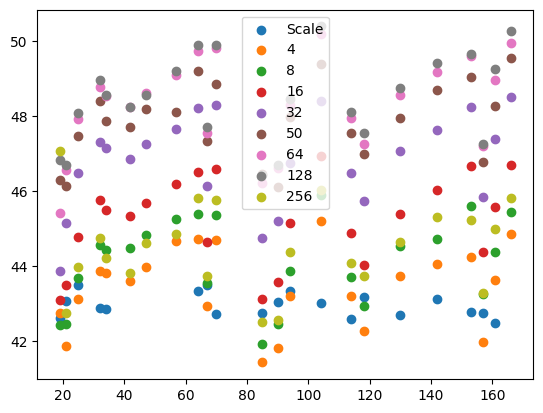

In [30]:
plt.scatter(times, TBW_weight, label='Scale')
# plt.scatter(times, TBW_const, label='Scale2')
# plt.scatter(times, Imp_post[50]/np.average(Imp_post[50]) * np.nanmean(TBW_weight),label=50)
R_adjusted = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
TBW_adjusted = {4:[],8:[],16:[],32:[],50:[],64:[],128:[],256:[]}
freq = [4,8,16,32,50,64,128,256]
for i in freq:
  R_adjusted[i] = np.array(R_post[i]) / 1.6503923254044435
  TBW_adjusted[i] = 1.2 + 0.45 * 173**2 / R_adjusted[i] + 0.18 * 69
for f in freq:
  plt.scatter(times, TBW_adjusted[f], label=f)
plt.legend()

In [ ]:
for frequency in R_post.keys():
    filename = f"week_testing_at_{frequency}kHz.csv"
    filepath = os.path.join(directory_path, filename)

    with open(filepath, 'w') as file:
        file.write("Time From Start,R,Xc,Imp,Pha,Gender,Age,Height,Weight,Real TBW,TBW w/ Constant Weight @ 69kg\n")

        for i in range(len(R_post[frequency])):
            row_data = [str(times[i]-times[0]),str(R_post[frequency][i]), str(Xc_post[frequency][i]), str(Imp_post[frequency][i]), str(Pha_post[frequency][i]),
                        '1','22.6','173',str(real_weight[i]), str(TBW_weight[i]), str(TBW_const[i])]
            file.write(",".join(row_data) + "\n")